# Self-Supervised Learning

In this Notebook we will show the efficiency of Self Supervised Learning with a very simple example.

The goal here is to classify cats and dogs. Yet we don't have enough labelled data to used a classical supervised learning algorithm. Labelling data can be very long and expensive. 
Then we decide to use **Self Supervised Learning**

We take our whole dataset and perform a 90° and a 180° rotation on every images. Now we have a dataset with labels (90 rot and 180 rot). We can train a Convolutional Neural Network to predict the rotation degree. 
As soon as the network is sufficiently trained we can go back to our dogs and cats classification task.
We are going to use our pre trained rotation network to make our classification. Since the network has already been trained on detecting edges and other cats and dogs components (nose, eyes, etc...) the classification should be more easy and thus require less labelled data.

In [ ]:
import sys
import os
import matplotlib.pyplot as plt
import pytorch_memory_monitor as pymm

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import CatsDogsRotateDatasets, CatsDogsDatasets, show_tensor_images
from ssl_model import RotateClassifier
import glob
import torch.nn as nn

In [ ]:
torch.cuda.empty_cache()
pymm.get_tensor_info()
pymm.get_gpu_memory_info()

## 1. ROTATION CLASSIFICATION

### 1.1 Load Datasets Objects

In [ ]:
dset_val = CatsDogsRotateDatasets(sub_percent=[.0, .025])
dset_train = CatsDogsRotateDatasets(sub_percent=[.1, .2])
dset_test = CatsDogsRotateDatasets(sub_percent=[.4, .425])

dataloader_val = DataLoader(dset_val, batch_size=len(dset_val),
                        shuffle=True, num_workers=0)
dataloader_train = DataLoader(dset_train, batch_size=16,
                        shuffle=True, num_workers=0)
dataloader_test = DataLoader(dset_test, batch_size=len(dset_test),
                        shuffle=True, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"len val: {len(dset_val)} \nlen train:  {len(dset_train)} \nlen test:  {len(dset_test)}")

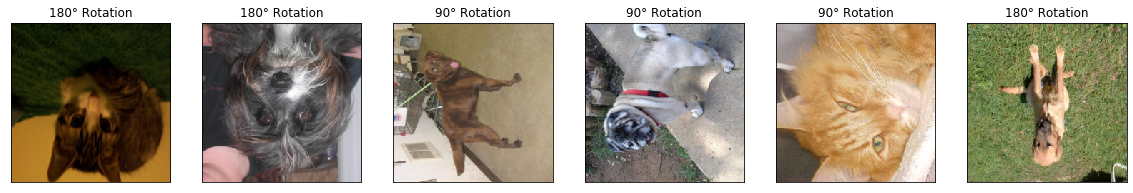

In [11]:
images_test, labels_test = next(iter(dataloader_test))
show_tensor_images(images_test, labels_test, ('90° Rotation', '180° Rotation'), n_images=6)

Here, the goal of the classifier is to determine if a 90 degrees rotation or a 180 degrees rotation has been applied to the image. **The labeling task - for the rotation - is free** and our classifier will train on our data. Thus It will train on detecting edges and structures among our datasets. Note that, the idea of cats and dogs are not important here.

### 1.2 Init CNN

In [ ]:
rotate_classifier = RotateClassifier()
rotate_classifier = rotate_classifier.to(device)
PATH = "rotate_classifier_50_epoch.pt"

#rotate_classifier.load_state_dict(torch.load(PATH))

### 1.3 Training components

In [ ]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(rotate_classifier.parameters(), lr=0.00001, betas=(0.9, 0.999))
loss_history = list()
val_acc_history = list()

In [ ]:
n_epoch = 50
running_loss = 0.0
viz_every = 100
plot = False

In [ ]:
rotate_classifier.train()
for epoch in range(n_epoch):
    for i_batch, (images, labels) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)

        pred = rotate_classifier(images)
        loss = criterion(pred.squeeze(), labels.to(torch.float32))
        loss.backward()
        optimizer.step()

        # print statistics
        loss_value = loss.item()
        running_loss += loss_value
        
        if i_batch % viz_every == (viz_every - 1):
            rotate_classifier.eval()
            images_val, labels_val = next(iter(dataloader_val))
            with torch.no_grad():
                pred_val = rotate_classifier(images_val.to(device))
            predicted = (pred_val > .5).float()
            c = (predicted.squeeze() == labels_val.to(device))
            
            mean_loss = running_loss / viz_every
            val_acc = float(torch.sum(c)/c.shape[0])
            
            print(f"[{epoch + 1}\t {i_batch + 1}]\t loss: {round(mean_loss, 5)}\t val acc: {round(val_acc, 4)}")
            
            loss_history.append(mean_loss)
            val_acc_history.append(val_acc)
            
            if plot:
                plt.plot(range(len(loss_history)), loss_history, label="loss")
                plt.legend()
                plt.show()
                
            running_loss = 0.0
            rotate_classifier.train()

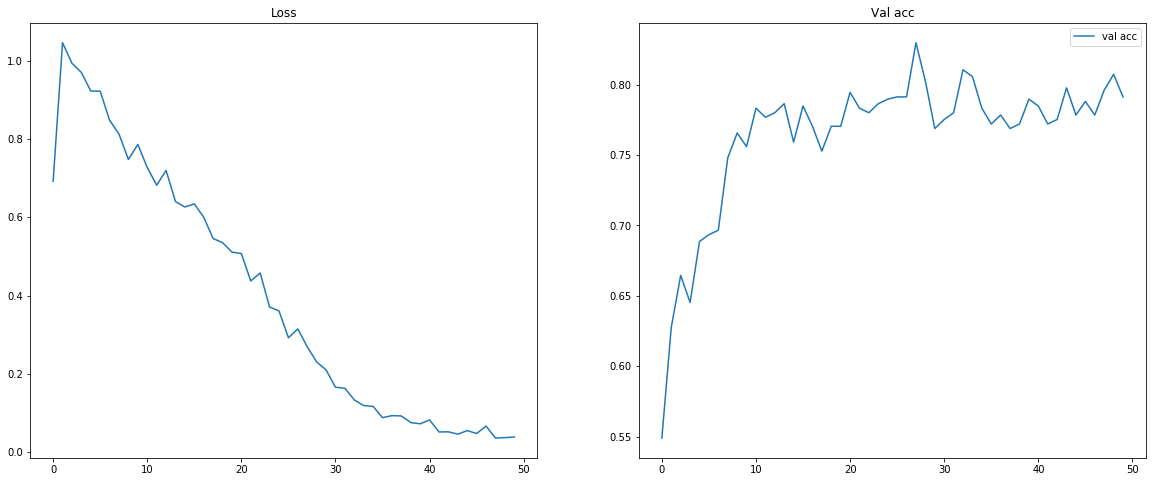

In [12]:
_, axis = plt.subplots(1, 2, figsize=(20, 8))
axis[0].plot(range(len(loss_history)), loss_history, label="loss")
axis[0].set_title('Loss')
axis[1].plot(range(len(val_acc_history)), val_acc_history, label="val acc")
axis[1].set_title('Val acc')
plt.legend()
plt.show()

In [ ]:
#torch.save(rotate_classifier.state_dict(), "rotate_classifier_cat_dog_100_epoch.pt")

### 1.4 Get test set accuracy

In [16]:
rotate_classifier.eval()
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_test):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = rotate_classifier(inputs)
        preds = (outputs > .5).float()
        c = (preds.squeeze() == classes.to(device))
        print(f"test set acc: {torch.sum(c)/c.shape[0]}")
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                
rotate_classifier.train()
print(confusion_matrix)

test set acc: 0.7849116921424866
tensor([[232.,  81.],
        [ 53., 257.]])


## 2. Cats and Dogs Classification

We will use an embedded layer from the Rotate Classifier we just trained. As a baseline we will train the same network architecture on our dataset. On the pretrained classifier, **only 50%** of the training set will be used.

In [25]:
cd_classifier_self_learning = RotateClassifier()
cd_classifier_baseline = RotateClassifier()

cd_classifier_self_learning = cd_classifier_self_learning.to(device)
cd_classifier_baseline = cd_classifier_baseline.to(device)

Load weights from rotation classifier and replace fully connected part with trainable layers

In [26]:
PATH = "rotate_classifier_50_epoch.pt"

cd_classifier_self_learning.load_state_dict(torch.load(PATH))

for param in cd_classifier_self_learning.parameters():
    param.requires_grad = False
    
cd_classifier_self_learning.fc = nn.Sequential(
    nn.Linear(64*28*28, 32),
    nn.LeakyReLU(.2),
    nn.Linear(32, 16),
    nn.LeakyReLU(.2),
    nn.Dropout(0.5),
    nn.Linear(16, 1),
    nn.Sigmoid()
).to(device)

### 2.1 Load Datasets Objects

In [27]:
dset_val = CatsDogsDatasets(sub_percent=[.0, .025])
dset_train = CatsDogsDatasets(sub_percent=[.1, .2])
dset_test = CatsDogsDatasets(sub_percent=[.4, .425])

dataloader_val = DataLoader(dset_val, batch_size=len(dset_val),
                        shuffle=True, num_workers=0)
dataloader_train = DataLoader(dset_train, batch_size=16,
                        shuffle=True, num_workers=0)
dataloader_test = DataLoader(dset_test, batch_size=len(dset_test),
                        shuffle=True, num_workers=0)

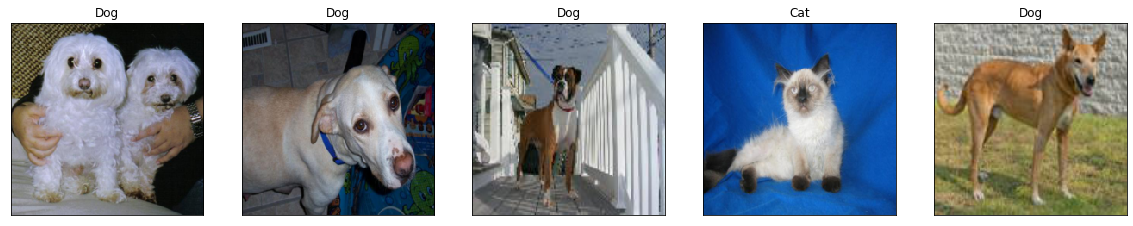

In [28]:
images_test, labels_test = next(iter(dataloader_test))
show_tensor_images(images_test, labels_test, ('Cat', 'Dog'), n_images=5)

## Training components

In [29]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(cd_classifier_self_learning.parameters(), lr=0.00001, betas=(0.9, 0.999))
loss_history = list()
val_acc_history = list()

criterion_baseline = torch.nn.BCELoss()
optimizer_baseline = torch.optim.Adam(cd_classifier_baseline.parameters(), lr=0.000005, betas=(0.9, 0.999))
loss_history_baseline = list()
val_acc_history_baseline = list()

In [30]:
n_epoch = 10
viz_every = 100
plot = False
training_subset_percent = .5

running_loss = 0.0
running_loss_baseline = 0.0

In [ ]:
cd_classifier_self_learning.train()

for epoch in range(n_epoch):
    for i_batch, (images, labels) in enumerate(dataloader_train):
        images, labels = images.to(device), labels.to(device)
        images_self_supervised = int(len(images)*training_subset_percent)
        
        # get classifiers preds and score on training set
        pred = cd_classifier_self_learning(images[:images_self_supervised])
        loss = criterion(pred.squeeze(), labels[:images_self_supervised].to(torch.float32))
        loss.backward()
        optimizer.step()
        
        pred = cd_classifier_baseline(images)
        loss_baseline = criterion_baseline(pred.squeeze(), labels.to(torch.float32))
        loss_baseline.backward()
        optimizer_baseline.step()

        # print statistics
        loss_value = loss.item()
        running_loss += loss_value
        
        loss_value_baseline = loss_baseline.item()
        running_loss_baseline += loss_value_baseline
        
        if i_batch % viz_every == viz_every - 1:
            cd_classifier_self_learning.eval()
            cd_classifier_baseline.eval()
            
            images_val, labels_val = next(iter(dataloader_val))
            with torch.no_grad():
                pred_val = cd_classifier_self_learning(images_val.to(device))
                pred_val_baseline = cd_classifier_baseline(images_val.to(device))
                
            predicted = (pred_val > .5).float()
            c = (predicted.squeeze() == labels_val.to(device))
            
            predicted_baseline = (pred_val_baseline > .5).float()
            c_baseline = (predicted_baseline.squeeze() == labels_val.to(device))
            
            mean_loss = running_loss / viz_every
            val_acc = float(torch.sum(c)/c.shape[0])
            
            mean_loss_baseline = running_loss_baseline / viz_every
            val_acc_baseline = float(torch.sum(c_baseline)/c_baseline.shape[0])
            
            print(f"[{epoch + 1}\t {i_batch + 1}]\t self lea loss: {round(mean_loss, 5)}\t self lea val acc: {round(val_acc, 4)}")
            print(f"[{epoch + 1}\t {i_batch + 1}]\t baseline loss: {round(mean_loss_baseline, 5)}\t baseline val acc: {round(val_acc_baseline, 4)}")
            
            loss_history.append(mean_loss)
            val_acc_history.append(val_acc)
            
            loss_history_baseline.append(mean_loss_baseline)
            val_acc_history_baseline.append(val_acc_baseline)
                
            running_loss = 0.0
            running_loss_baseline = 0.0
            
            cd_classifier_self_learning.train()
            cd_classifier_baseline.train()
            

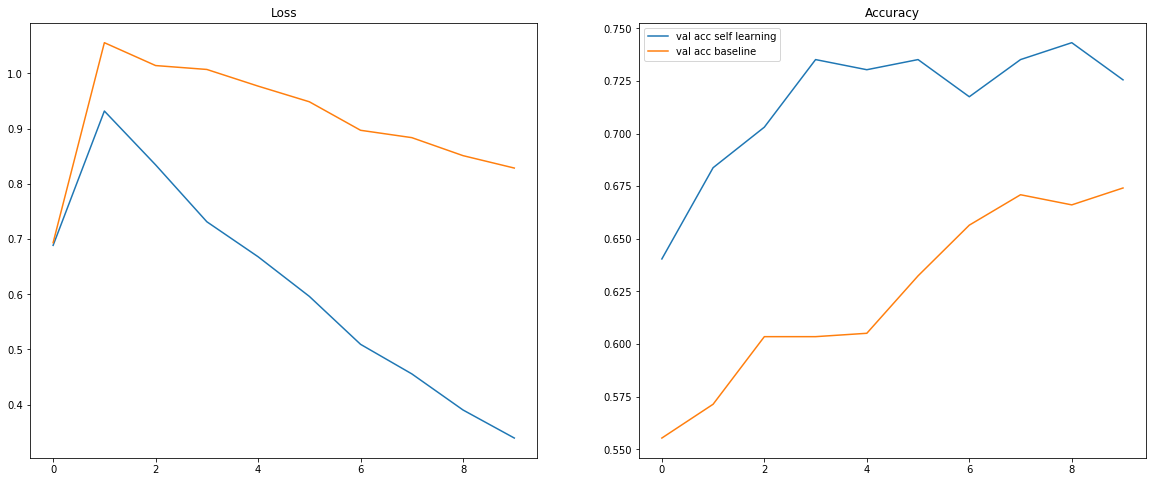

In [32]:
_, axis = plt.subplots(1, 2, figsize=(20, 8))

axis[0].plot(range(len(loss_history)), loss_history, label="loss self learning")
axis[0].plot(range(len(loss_history_baseline)), loss_history_baseline, label="loss baseline")
axis[0].set_title('Loss')

axis[1].plot(range(len(val_acc_history)), val_acc_history, label="val acc self learning")
axis[1].plot(range(len(val_acc_history_baseline)), val_acc_history_baseline, label="val acc baseline")
axis[1].set_title('Accuracy')

plt.legend()
plt.show()

Our classifier with pretrained weights (on rotation task) performs better that the other one. **We got here a better result with a smaller amount of labelled data.** 

In [34]:
rotate_classifier.eval()
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
confusion_matrix_baseline = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_test):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = cd_classifier_self_learning(inputs)
        outputs_baseline = cd_classifier_baseline(inputs)
        preds = (outputs > .5).float()
        preds_baseline = (outputs_baseline > .5).float()
        c = (preds.squeeze() == classes.to(device))
        c_baseline = (preds_baseline.squeeze() == classes.to(device))
        print(f"self supervised learning test set acc: {torch.sum(c)/c.shape[0]}")
        print(f"baseline test set acc: {torch.sum(c_baseline)/c_baseline.shape[0]}")
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        for t, p in zip(classes.view(-1), preds_baseline.view(-1)):
                confusion_matrix_baseline[t.long(), p.long()] += 1
                
cd_classifier_self_learning.train()
cd_classifier_baseline.train()
print("self supervised learning")
print(confusion_matrix)

test set acc: 0.5184590816497803
tensor([[262.,  46.],
        [128., 187.]])
